In [1039]:
##### import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import pandas_profiling
import datetime
from datetime import date

In [1040]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats

### Read the data

In [1041]:
data = pd.read_csv("...DatafinitiElectronicsProductsPricingData.csv")
data.head(1)

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,USD,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,...,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,7.93796E+11,32.8 pounds,NaN,NaN,NaN,NaN,NaN


In [1042]:
data.dtypes

id                      object
prices.amountMax       float64
prices.amountMin       float64
prices.availability     object
prices.condition        object
prices.currency         object
prices.dateSeen         object
prices.isSale             bool
prices.merchant         object
prices.shipping         object
prices.sourceURLs       object
asins                   object
brand                   object
categories              object
dateAdded               object
dateUpdated             object
ean                     object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
name                    object
primaryCategories       object
sourceURLs              object
upc                     object
weight                  object
Unnamed: 26             object
Unnamed: 27             object
Unnamed: 28            float64
Unnamed: 29             object
Unnamed: 30             object
dtype: object

In [1043]:
data_train_non_trans = data[['id',
                'prices.availability',
               'prices.condition',
                'prices.dateSeen',
               'prices.isSale',
               'prices.merchant',
               'prices.shipping',
                'sourceURLs',
               'brand',
               'categories',
               'dateAdded',
               'dateUpdated',
               'manufacturer',
               'manufacturerNumber',
               'name',
               'primaryCategories',
               'weight',
               'prices.currency',
               'prices.amountMin',
               'prices.amountMax']]

### Data Explore

In [1044]:
#As we can see, there are different currencies in our data. Let's transform everything to USD

In [1045]:
data_train_non_trans['prices.currency'].unique()

array(['USD', 'CAD', 'SGD', 'EUR', 'GBP'], dtype=object)

In [1046]:
data_train_non_trans['price_USD'] = data_train_non_trans['prices.amountMax']
data_train_non_trans['price_USD'] = np.where(data_train_non_trans['prices.currency'] == 'CAD',
                                           data_train_non_trans['price_USD'] * 0.8,
                                           np.where(data_train_non_trans['prices.currency'] == 'SGD',
                                                    data_train_non_trans['price_USD'] * 0.74,
                                                   np.where(data_train_non_trans['prices.currency'] == 'EUR',
                                                            data_train_non_trans['price_USD'] * 1.17,
                                                            data_train_non_trans['price_USD'])))

C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\I347687\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1047]:
weight_table_1 = np.unique(data_train_non_trans[['weight']])

In [1048]:
weight_table = sqldf("SELECT DISTINCT weight from data_train_non_trans")

In [1049]:
weight_table = pd.DataFrame(data_train_non_trans.weight.str.split(' ',1).tolist(),
                                 columns = ['weight_num','weight_metric'])

In [1050]:
#As we can see, product weight is measured in different units. Let's transform everything into pounds

In [1051]:
weight_table.weight_metric.unique()

array(['pounds', 'lb 2.6 lb 1.6 lb 18.7 lb', 'lb', 'ounces', 'oz', 'lbs',
       'lbs                                                                                      1.8 pounds',
       None,
       'lb                                                                                      12.8 ounces',
       'oz 3.2 oz',
       'lbs                                                                                                2 pounds',
       'lb                                                                                                8 ounces',
       'lbs                                                                                                2.96 pounds',
       'lb                                                                                                9.9 ounces',
       'lb. 8 oz.',
       'ounces                                                                                      6.9 ounces',
       'lbs                                                      

In [1052]:
weight_table.at[536:541,'weight_num']=np.NaN
weight_table.at[6187:6213,'weight_num']=np.NaN

In [1053]:
weight_table['weight_num'] = weight_table['weight_num'].astype(float)

In [1054]:
sqldf("select weight_metric, count(*) from weight_table group by weight_metric order by count(*) DESC")

,weight_metric,count(*)
0,pounds,5989
1,lb,2803
2,ounces,2488
3,oz,1098
4,lbs,619
...,...,...
81,lbs ...,2
82,lbs ...,2
83,ounces ...,2
84,ounces ...,2


In [1055]:
weight_table['weight_norm'] = np.where(weight_table['weight_metric'] == 'ounces',
                                           weight_table['weight_num'] * 0.0625,
                                           np.where(weight_table['weight_metric'] == 'oz',
                                                    weight_table['weight_num'] * 0.0625,
                                                   np.where(weight_table['weight_metric'] == 'OUNCE',
                                                            weight_table['weight_num'] * 0.0625,
                                                            np.where(weight_table['weight_metric'] == 'g',
                                                                    weight_table['weight_num'] * 0.0022046226218,
                                                                       np.where(weight_table['weight_metric'] == 'kg',
                                                                               weight_table['weight_num'] * 2.20462262185,
                                                                                np.where(weight_table['weight_metric'] == 'Kg',
                                                                                   weight_table['weight_num'] * 2.20462262185,
                                                                                        np.where(weight_table['weight_metric'] == 'oz 0.8 oz',
                                                                                           weight_table['weight_num'] * 0.0625,
                                                                                           np.where(weight_table['weight_metric'] == 'oz 10.41 oz',
                                                                                                    weight_table['weight_num'] * 0.0625,
                                                                                                   np.where(weight_table['weight_metric'] == 'oz 10.6 oz 1.1 lb',
                                                                                                            weight_table['weight_num'] * 0.0625,
                                                                                                            np.where(weight_table['weight_metric'] == 'oz 2.9 oz',
                                                                                                                    weight_table['weight_num'] * 0.0625,
                                                                                                                       np.where(weight_table['weight_metric'] == 'oz 3.2 oz',
                                                                                                                               weight_table['weight_num'] * 0.0625,
                                                                                                                                np.where(weight_table['weight_metric'] == 'oz 3.88 oz 8.2 oz',
                                                                                                                                   weight_table['weight_num'] * 0.0625,
                                                                                                                                         np.where(weight_table['weight_metric'] == 'oz 4.09 oz',
                                                                                                                                           weight_table['weight_num'] * 0.0625,
                                                                                                                                                  np.where(weight_table['weight_metric'] == 'oz 4.09 oz 12.17 oz',
                                                                                                                                                       weight_table['weight_num'] * 0.0625,
                                                                                                                                                          np.where(weight_table['weight_metric'] == 'oz 4.09 oz 8.5 oz 3.1 oz',
                                                                                                                                                               weight_table['weight_num'] * 0.0625,
                                                                                                                                                                    np.where(weight_table['weight_metric'] == 'oz 4.6 oz',
                                                                                                                                                                           weight_table['weight_num'] * 0.0625,
                                                                                                                                                                              np.where(weight_table['weight_metric'] == 'oz 7.23 oz 14.110 oz',
                                                                                                                                                                                   weight_table['weight_num'] * 0.0625,
                                                                                                                                                                                      weight_table['weight_num'])))))))))))))))))

In [1056]:
weight_table.at[5191:5202,'weight_norm']=np.NaN

In [1057]:
data_train_non_trans_merge = pd.merge(data_train_non_trans, weight_table, left_index=True, right_index=True)

In [1058]:
data_train_non_trans_merge.head(1)

,id,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,sourceURLs,brand,categories,...,name,primaryCategories,weight,prices.currency,prices.amountMin,prices.amountMax,price_USD,weight_num,weight_metric,weight_norm
0,AVphzgbJLJeJML43fA0o,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,32.8 pounds,USD,104.99,104.99,104.99,32.8,pounds,32.8


In [1059]:
#As we can see, column categories is text splited by comma. Let's split it into several columns

In [1060]:
data_train_non_trans_merge[['categories']]

,categories
0,"Audio & Video Accessories,TV Mounts,TV Accesso..."
1,"Stereos,Portable Bluetooth Speakers,TV, Video ..."
2,"Stereos,Portable Bluetooth Speakers,TV, Video ..."
3,"Stereos,Portable Bluetooth Speakers,TV, Video ..."
4,"Stereos,Portable Bluetooth Speakers,TV, Video ..."
...,...
14587,"TVs & Electronics,Computers,Home Theater & Aud..."
14588,"TVs & Electronics,Computers,Home Theater & Aud..."
14589,"TVs & Electronics,Computers,Home Theater & Aud..."
14590,"TVs & Electronics,Computers,Home Theater & Aud..."


In [1061]:
pd.concat([data_train_non_trans_merge,data_train_non_trans_merge.categories.str.split(',', n=6, expand=True)],1).head(1)

,id,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,sourceURLs,brand,categories,...,weight_num,weight_metric,weight_norm,0,1,2,3,4,5,6
0,AVphzgbJLJeJML43fA0o,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,32.8,pounds,32.8,Audio & Video Accessories,TV Mounts,TV Accessories & Parts,Electronics,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts


In [1062]:
data_train_non_trans_merge=pd.concat([data_train_non_trans_merge,data_train_non_trans_merge.categories.str.split(',', n=6, expand=True)],1)

In [1063]:
data_train_non_trans_merge.head(1)

,id,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,sourceURLs,brand,categories,...,weight_num,weight_metric,weight_norm,0,1,2,3,4,5,6
0,AVphzgbJLJeJML43fA0o,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,32.8,pounds,32.8,Audio & Video Accessories,TV Mounts,TV Accessories & Parts,Electronics,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts


In [1064]:
#As we can see, column prices.condition has a lot of "strange values" and some of them can also be grouped. 
#(e.g. classes Refurbished, refurbished and refurbished has the same meaning)

In [1065]:
data_train_non_trans_merge['prices.condition'].unique()

array(['New', 'new', 'Seller refurbished', 'Used', 'pre-owned',
       'Refurbished', 'Manufacturer refurbished',
       'New other (see details)', 'refurbished',
       'New Kicker BT2 41IK5BT2V2 Wireless Bluetooth USB Audio System Black + Remote, Power Supply (volts, ampere): 24, 2.9, Square Reflex Subwoofer (in., mm): 6 x 6", Stereo Amp Power with DSP (watts): 50, App for customizing - KickStart, Remote Control Included, Height x Width x Depth (in, mm): 8.87" x 19" x 9.14", Frequency Response (Hz): 24-20k, +-3dB, Woofer (in., cm): 5", 1 Year Manufacturer Warranty, Item Weight: 13.85 lbs., USB Port, Compatible with: Bluetooth-enabled devices, Aux-in, Speaker Design: 2-Way Full-Range, Bluetooth wireless streaming, Condition: Brand New!, Tweeter (in., cm): 3/4"',
       '5/16" Ring Terminal, 3 ft. 8 GA Black Ground Cable, 6 ft. Split Loom Tubing, Depth: 6.5" (165mm) (top) 11.2" (285mm) (bottom), Item Weight: 18.5 lbs., Frequency Response 25Hz - 500Hz, Line Output, Max Power: 1100 Watt 

In [1066]:
data_train_non_trans_merge.at[878:879,'prices.condition']="New"
data_train_non_trans_merge.loc[7473,'prices.condition'] = "New"
data_train_non_trans_merge.loc[9925,'prices.condition'] = "Refubrished"
data_train_non_trans_merge.loc[2592,'prices.condition'] = "New"
data_train_non_trans_merge.loc[7474,'prices.condition'] = "New"
data_train_non_trans_merge.loc[12143,'prices.condition'] = "New"
data_train_non_trans_merge.loc[14279,'prices.condition'] = "New"

In [1067]:
data_train_non_trans_merge['prices.condition'] = np.where(data_train_non_trans_merge['prices.condition'] == "Brand New", "New", data_train_non_trans_merge['prices.condition'])

In [1068]:
data_train_non_trans_merge["prices.condition"].unique()

array(['New', 'new', 'Seller refurbished', 'Used', 'pre-owned',
       'Refurbished', 'Manufacturer refurbished',
       'New other (see details)', 'refurbished', nan, 'Refubrished',
       'For parts or not working'], dtype=object)

In [1069]:
#As we can see, prices.shipping has a lot of "strange values". Let us also take care of this variable

In [1070]:
data_train_non_trans_merge['prices.shipping'].unique()

array([nan, 'Expedited', 'Value', 'Standard', 'Free Shipping',
       'Free Shippingon orders 35 and up', 'Free Expedited Shipping',
       'Free Shipping on orders 35 and up',
       'Free Expedited Shipping for most orders over $49', 'FREE',
       'Freight', 'Free Shipping for this Item', 'USD 7.95', 'USD 7.25',
       'USD 26.09', 'USD 10.00',
       'Free Standard Shipping on Orders Over $49', 'Free Delivery',
       'USD 11.30', 'USD 15.42', 'USD 35.03', 'USD 0.99',
       'Shipping Charges Apply', 'USD 60.00', 'USD 15.68', 'USD 5.99',
       'USD 196.92', 'USD 22.64', 'USD 20.00', 'USD 13.32', 'USD 12.78',
       'USD 13.25', 'USD 25.00', 'USD 6.65', 'USD 2.85', 'USD 7.81',
       'USD 10.10', 'USD 75.00', 'USD 13.95', 'Free Standard Shipping',
       'USD 20.55', 'USD 18.60', 'USD 11.75', 'USD 25.76', 'USD 27.94',
       'USD 14.00', 'USD 13.60', 'USD 5.00', 'USD 13.61', 'USD 3.99',
       'USD 7.50', 'USD 2.99', 'USD 12.21', 'USD 3.39', 'USD 22.13',
       'USD 6.00', 'USD 4.8

In [1071]:
data_train_non_trans_merge['prices.shipping'] = data_train_non_trans_merge['prices.shipping'].fillna("")

In [1072]:
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('Free'), 'shipping_flag'] = 'Free'
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('FREE'), 'shipping_flag'] = 'Free'
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('free'), 'shipping_flag'] = 'Free'
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('USD'), 'shipping_flag'] = 'Paid'
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('CAD'), 'shipping_flag'] = 'Paid'
data_train_non_trans_merge.loc[data_train_non_trans_merge['prices.shipping'].str.contains('GBP'), 'shipping_flag'] = 'Paid'

In [1073]:
data_train_non_trans_merge["shipping_flag"].fillna(data_train_non_trans_merge["prices.shipping"], inplace=True)

In [1074]:
data_train_non_trans_merge["shipping_flag"].unique()

array(['', 'Expedited', 'Value', 'Standard', 'Free', 'Freight', 'Paid',
       'Shipping Charges Apply', '2-4 days',
       'Same day if ordered before 4pm', '10-12 days', '4-6 days',
       '3-5 days', 'Call', '6-8 days', '1-3 days', '8-10 days',
       '7-9 days'], dtype=object)

In [1075]:
data_train_non_trans_merge.head(1)

,id,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,sourceURLs,brand,categories,...,weight_metric,weight_norm,0,1,2,3,4,5,6,shipping_flag
0,AVphzgbJLJeJML43fA0o,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,pounds,32.8,Audio & Video Accessories,TV Mounts,TV Accessories & Parts,Electronics,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts,


### Dataset enrichment

In [1076]:
#Since we have date when product was introduced and updated in the system, let's create 2 variables, which could help us to predict the price:
# 1) N days since the product was added
# 2) N days since the product was updated

In [1077]:
data_train_non_trans_merge['dateAdded_t'] = pd.to_datetime(data_train_non_trans_merge['dateAdded'],format='%Y-%m-%dT%H:%M:%SZ')

In [1078]:
data_train_non_trans_merge['dateAdded_t']

0       2015-04-13 12:00:51
1       2015-05-18 14:14:56
2       2015-05-18 14:14:56
3       2015-05-18 14:14:56
4       2015-05-18 14:14:56
                ...        
14587   2015-09-11 02:03:11
14588   2015-09-11 02:03:11
14589   2015-09-11 02:03:11
14590   2015-09-11 02:03:11
14591   2015-09-11 02:03:11
Name: dateAdded_t, Length: 14592, dtype: datetime64[ns]

In [1079]:
data_train_non_trans_merge['n_days_since_added'] = (datetime.datetime.utcnow() - data_train_non_trans_merge['dateAdded_t']).dt.days

In [1080]:
data_train_non_trans_merge['dateUpdated_t'] = pd.to_datetime(data_train_non_trans_merge['dateUpdated'],format='%Y-%m-%dT%H:%M:%SZ')
data_train_non_trans_merge['n_days_since_updated'] = (datetime.datetime.utcnow() - data_train_non_trans_merge['dateUpdated_t']).dt.days

In [1081]:
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[1]: "prices_availability"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[2]: "prices_condition"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[3]: "prices_dateSeen"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[4]: "prices_isSale"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[5]: "prices_merchant"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[6]: "prices_shipping"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[17]: "prices_currency "}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[18]: "prices_amountMin"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[19]: "prices_amountMax"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[24]: "category_0"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[25]: "category_1"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[26]: "category_2"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[27]: "category_3"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[28]: "category_4"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[29]: "category_5"}, inplace = True)
data_train_non_trans_merge.rename(columns={ data_train_non_trans_merge.columns[30]: "category_6"}, inplace = True)

In [1082]:
#Let's add some competition context data into
# -> Frist, we are going to query: How many different merchants/retailers are selling the same product? (prices_merchant_y)
# -> Second, we are go query: How many different brands are selling products from the same category (brand_y)
# The main idea is the following: If product is sold by several merchants and not only single one, then it can be reflected on the price. Same logic about for brand

In [1083]:
id_merch=data_train_non_trans_merge.groupby('id')['prices_merchant'].nunique().to_frame()

In [1084]:
id_merch

,prices_merchant
id,
AV-pPOFauC1rwyj_ghHT,2
AV0-JbjHvKc47QAVgW-C,6
AV00ozTAvKc47QAVgAJM,5
AV01QNi7vKc47QAVgEEV,7
AV01UxMTglJLPUi8Hmm4,7
...,...
AWOpLyzrHh53nbDRKmTD,4
AWOpMDbqYSSHbkXw06lc,1
AWOpOCd2YSSHbkXw07ei,1


In [1085]:
data_train_non_trans_merge = pd.merge(data_train_non_trans_merge, id_merch, on='id')

In [1086]:
id_brand=data_train_non_trans_merge.groupby('id')['brand'].nunique().to_frame()

In [1087]:
brand_category = data_train_non_trans_merge.groupby('category_2')['brand'].nunique()

In [1088]:
data_train_non_trans_merge = pd.merge(data_train_non_trans_merge, brand_category, on='category_2')

In [1089]:
data_train_non_trans_merge.head(1)

,id,prices_availability,prices_condition,prices_dateSeen,prices_isSale,prices_merchant_x,prices_shipping,sourceURLs,brand_x,categories,...,category_4,category_5,category_6,shipping_flag,dateAdded_t,n_days_since_added,dateUpdated_t,n_days_since_updated,prices_merchant_y,brand_y
0,AVphzgbJLJeJML43fA0o,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts,,2015-04-13 12:00:51,2317,2018-05-12 18:59:48,1191,1,2


In [1090]:
# Let's do some data cleansing on prices_availability variable. As we can see, there are different values that represents the same

In [1091]:
data_train_non_trans_merge.prices_availability.unique()

array(['Yes', 'TRUE', nan, 'In Stock', 'yes', 'undefined', 'Out Of Stock',
       'More on the Way', 'FALSE', 'Special Order', 'sold',
       'Limited Stock', '32 available', '7 available', 'No',
       'Discontinued', 'Retired', 'More Coming Soon'], dtype=object)

In [1092]:
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'Yes'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'yes'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'TRUE'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == '7 available'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == '32 available'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'Limited Stock'),'prices_availability']='In Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'More on the Way'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'sold'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'Discontinued'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'No'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'FALSE'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'More Coming Soon'),'prices_availability']='Out Of Stock'
data_train_non_trans_merge.loc[(data_train_non_trans_merge.prices_availability == 'Retired'),'prices_availability']='Out Of Stock'

In [1093]:
data_train_non_trans_merge['prices_availability'].unique()

array(['In Stock', nan, 'undefined', 'Out Of Stock', 'Special Order'],
      dtype=object)

In [1094]:
data_train_non_trans_merge.head(3)

,id,prices_availability,prices_condition,prices_dateSeen,prices_isSale,prices_merchant_x,prices_shipping,sourceURLs,brand_x,categories,...,category_4,category_5,category_6,shipping_flag,dateAdded_t,n_days_since_added,dateUpdated_t,n_days_since_updated,prices_merchant_y,brand_y
0,AVphzgbJLJeJML43fA0o,In Stock,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts,,2015-04-13 12:00:51,2317,2018-05-12 18:59:48,1191,1,2
1,AWLI-DTQYSSHbkXwzTxw,In Stock,new,2018-05-02T14:00:00Z,False,Bestbuy.com,,https://www.amazon.com/Insignia-47-Full-Motion...,Insignia,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,Mounts & Furniture,Electronics,"Accessories & Supplies,TV & Home Theater,TV Ce...",,2018-04-15 10:02:33,1219,2018-05-12 19:03:27,1191,1,2
2,AVpffBUvilAPnD_xcj8r,NaN,NaN,"2018-04-16T20:00:00Z,2018-04-19T16:00:00Z,2018...",True,superior sales,FREE Shipping,http://www.amazon.com/Sanus-Visionmount-All-We...,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",...,Mounts & Furniture,Electronics,"Accessories & Supplies,TV & Home Theater,TV Ce...",Free,2015-10-30 23:12:22,2116,2018-06-13 19:38:47,1159,2,2


In [1095]:
data_train_non_trans_merge.at[13801,'prices_condition']='refurbished'

In [1096]:
# Now, let us remove the duplicated records

In [1097]:
duplicated = data_train_non_trans_merge.duplicated().to_frame()

In [1098]:
data_train_non_trans_merge_dup = pd.merge(data_train_non_trans_merge, duplicated, left_index=True, right_index=True)

In [1099]:
data_train_non_trans_merge_dup.rename(columns={ data_train_non_trans_merge_dup.columns[33]: "Flag_duplicated"}, inplace = True)

### Outliers

In [1100]:
#As we can see by the box plot, there are some possible outliers in price

<AxesSubplot:>

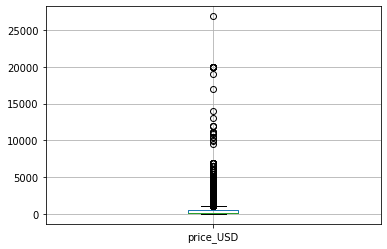

In [1101]:
data_train_non_trans_merge.boxplot(['price_USD'])

In [1102]:
data_train_non_trans_merge[['id', 'price_USD']].sort_values(by='price_USD', ascending=False)

,id,price_USD
458,AVph8rYRilAPnD_x_GYE,26871.00
14081,AV2ZqC3JglJLPUi8QkKo,19999.99
14079,AV2ZqC3JglJLPUi8QkKo,19999.99
14077,AV2ZqC3JglJLPUi8QkKo,19997.99
14082,AV2ZqC3JglJLPUi8QkKo,19997.99
...,...,...
8718,AVphOxQQ1cnluZ0-_-Nn,1.00
2547,AVpf-2hGilAPnD_xlfDv,1.00
8754,AVqVGaGiU2_QcyX9Ozcm,1.00
2384,AVqkI8oeU2_QcyX9O04K,1.00


In [1103]:
data_train_non_trans_merge = data_train_non_trans_merge.drop(458)

<AxesSubplot:>

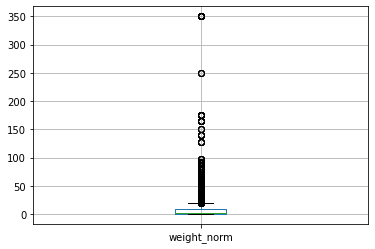

In [1104]:
data_train_non_trans_merge.boxplot(['weight_norm'])

In [1105]:
#Products with weight = 0
data_train_non_trans_merge.at[9620:9622,'weight_norm']=np.NaN
data_train_non_trans_merge.at[11683:11686,'weight_norm']=np.NaN

In [1106]:
data_train_non_trans_merge_final = data_train_non_trans_merge[['id',
                                                               'prices_availability',
                                                               'prices_condition',
                                                               'prices_isSale',
                                                               'prices_merchant_x',
                                                               'brand_x',
                                                               'manufacturer',
                                                               'manufacturerNumber',
                                                               'primaryCategories',
                                                               'weight_norm',
                                                               'category_0',
                                                               'category_1',
                                                               'category_2',
                                                               'category_3',
                                                               'category_4',
                                                               'category_5',
                                                               'category_6',
                                                               'shipping_flag',
                                                               'n_days_since_added',
                                                               'n_days_since_updated',
                                                               'prices_merchant_y',
                                                               'brand_y',
                                                               'price_USD']]

In [1107]:
duplicated = data_train_non_trans_merge_final.duplicated().to_frame()

In [1108]:
data_train_non_trans_merge_final_before_dup = data_train_non_trans_merge_final.copy()

In [1109]:
data_train_non_trans_merge_final_dup = pd.merge(data_train_non_trans_merge_final, duplicated, left_index=True, right_index=True)

In [1110]:
data_train_non_trans_merge_final_dup.rename(columns={ data_train_non_trans_merge_final_dup.columns[23]: "Flag_duplicated"}, inplace = True)

In [1111]:
data_train_non_trans_merge_final_dup = data_train_non_trans_merge_final_dup[data_train_non_trans_merge_final_dup['Flag_duplicated']==False]

In [1112]:
# Let's explore our data for missing values

In [1113]:
data_train_non_trans_merge_final_dup.isna().sum()/len(data_train_non_trans_merge_final_dup)*100

id                       0.000000
prices_availability     13.494981
prices_condition         9.614025
prices_isSale            0.000000
prices_merchant_x        5.153400
brand_x                  0.000000
manufacturer            47.483388
manufacturerNumber       0.000000
primaryCategories        0.000000
weight_norm              0.367595
category_0               0.000000
category_1               0.000000
category_2               0.000000
category_3               0.021207
category_4               0.155521
category_5               0.805882
category_6               1.611763
shipping_flag            0.000000
n_days_since_added       0.000000
n_days_since_updated     0.000000
prices_merchant_y        0.000000
brand_y                  0.000000
price_USD                0.000000
Flag_duplicated          0.000000
dtype: float64

In [1114]:
# 47% of "manufacturer" column is missed. Since we also have "manufacturerNumber", we can drop "manufacturer"

In [1115]:
data_train_non_trans_merge_final_dup = data_train_non_trans_merge_final_dup.drop('manufacturer', axis=1)

In [1116]:
# Let's fill prices_availability, prices_condition and prices_merchant_x by blanks

In [1117]:
data_train_non_trans_merge_final_dup['prices_availability'] = data_train_non_trans_merge_final_dup['prices_availability'].fillna("")
data_train_non_trans_merge_final_dup['prices_condition'] = data_train_non_trans_merge_final_dup['prices_condition'].fillna("")
data_train_non_trans_merge_final_dup['prices_merchant_x'] = data_train_non_trans_merge_final_dup['prices_merchant_x'].fillna("")

In [1118]:
# Do the same for category_3, category_4, category_5 and category_6

In [1119]:
data_train_non_trans_merge_final_dup['category_3'] = data_train_non_trans_merge_final_dup['category_3'].fillna("")
data_train_non_trans_merge_final_dup['category_4'] = data_train_non_trans_merge_final_dup['category_4'].fillna("")
data_train_non_trans_merge_final_dup['category_5'] = data_train_non_trans_merge_final_dup['category_5'].fillna("")
data_train_non_trans_merge_final_dup['category_6'] = data_train_non_trans_merge_final_dup['category_6'].fillna("")

In [1120]:
# In order to impute weight variable, we can use the median value of its product category

In [1121]:
data_train_non_trans_merge_final_dup['weight_norm'] = data_train_non_trans_merge_final_dup.weight_norm.fillna(data_train_non_trans_merge_final_dup.groupby('category_0').weight_norm.transform('median'))

In [1122]:
data_train_non_trans_merge_final_dup.isna().sum()/len(data_train_non_trans_merge_final_dup)*100

id                      0.0
prices_availability     0.0
prices_condition        0.0
prices_isSale           0.0
prices_merchant_x       0.0
brand_x                 0.0
manufacturerNumber      0.0
primaryCategories       0.0
weight_norm             0.0
category_0              0.0
category_1              0.0
category_2              0.0
category_3              0.0
category_4              0.0
category_5              0.0
category_6              0.0
shipping_flag           0.0
n_days_since_added      0.0
n_days_since_updated    0.0
prices_merchant_y       0.0
brand_y                 0.0
price_USD               0.0
Flag_duplicated         0.0
dtype: float64

In [1123]:
data_train_non_trans_merge_final_dup = data_train_non_trans_merge_final_dup.drop('Flag_duplicated',axis=1)

### Data Visualization

In [1124]:
#As we can see, the distribution is mostly got skewed to right side this is because of varying density in that price range. 
#This is our dependent variable. we have to predict this values using other attributes given.

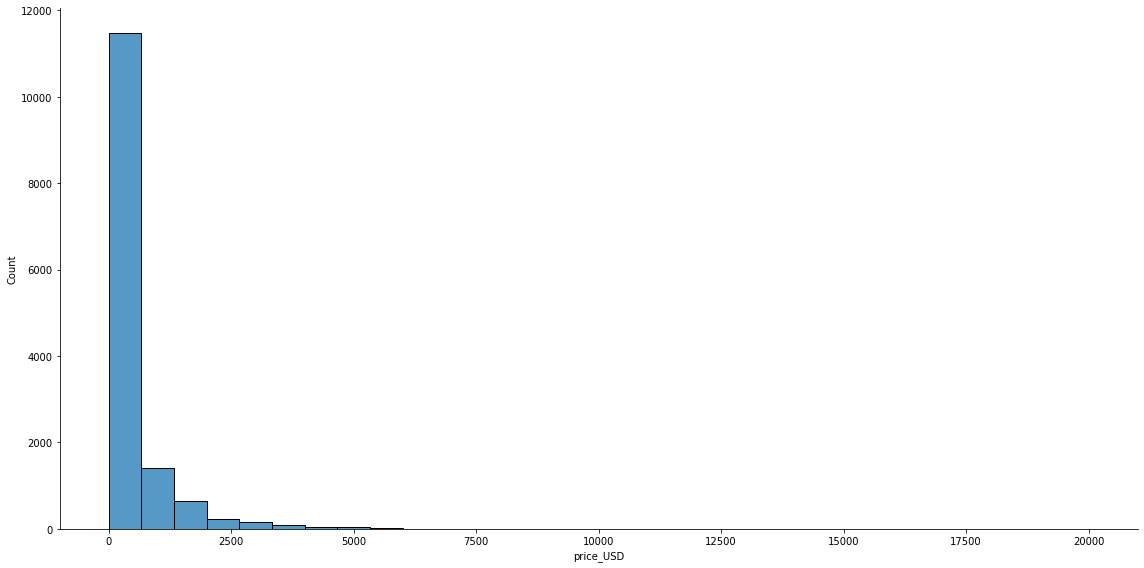

In [1125]:
sns.displot(data_train_non_trans_merge_final_dup, x="price_USD", bins=30, height=8, aspect=2)

In [1126]:
shipping_flag_explore = data_train_non_trans_merge_final_dup[(data_train_non_trans_merge_final_dup["shipping_flag"] == 'Same day if ordered before 4pm') | (data_train_non_trans_merge_final_dup["shipping_flag"] == 'Paid')]

In [1127]:
#Let us see how price got skewed with shipping attribute

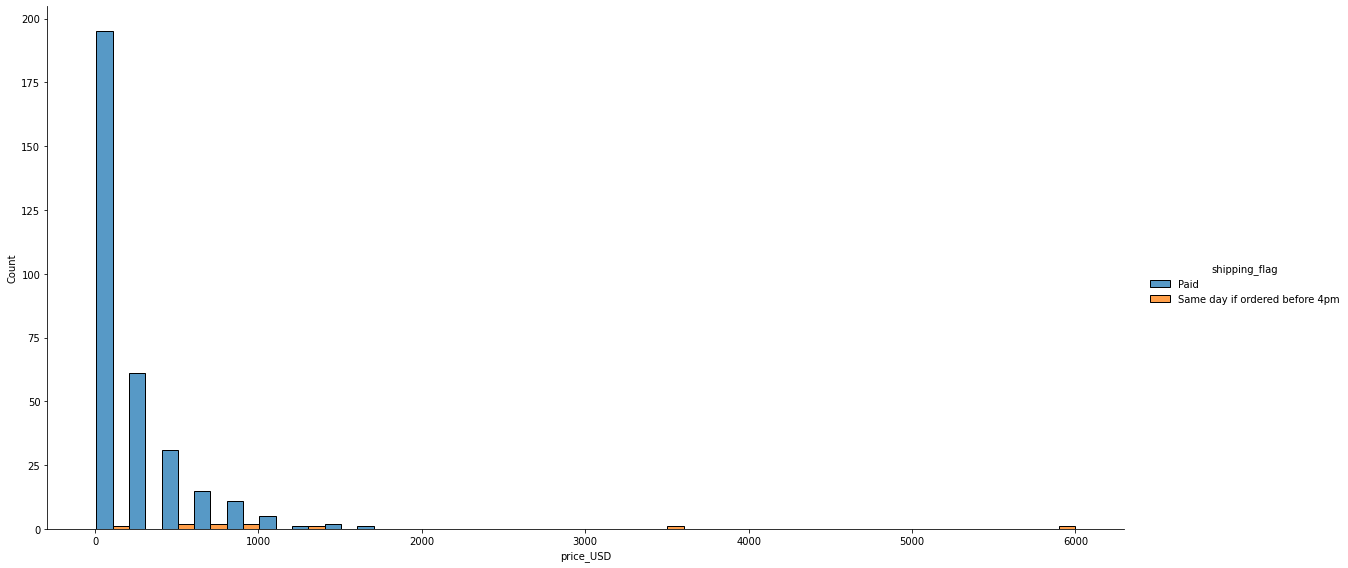

In [1128]:
sns.displot(shipping_flag_explore, x="price_USD", hue = 'shipping_flag', multiple='dodge', bins=30, height=8, aspect=2)

In [1129]:
category_explore = data_train_non_trans_merge_final_dup[(data_train_non_trans_merge_final_dup["category_4"] == 'Accessories') | (data_train_non_trans_merge_final_dup["category_4"] == 'All Cameras')]

In [1130]:
#As we can see the price changes depending on shipping
#Obvisoly products, which shipping is done in the same day has a very high cost

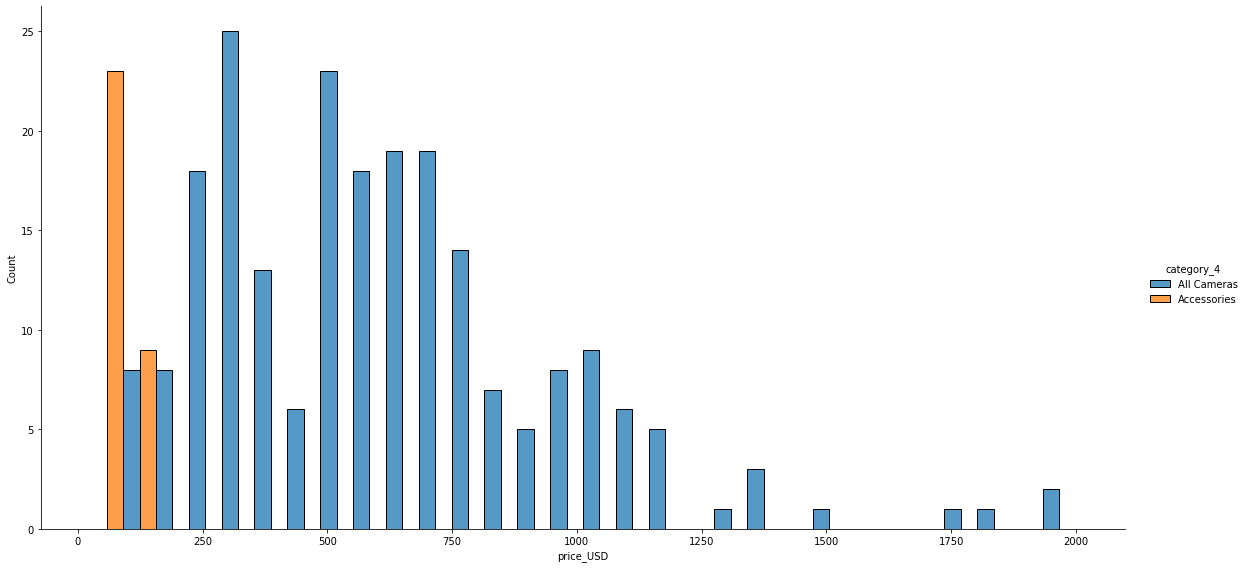

In [1131]:
sns.displot(category_explore, x="price_USD", hue ='category_4', multiple='dodge', bins=30, height=8, aspect=2)

In [1132]:
data_train_non_trans_merge_final_dup.pivot_table(index=['shipping_flag'], values=['price_USD'], aggfunc=np.median)

,price_USD
shipping_flag,
,177.745
1-3 days,123.990
10-12 days,61.990
2-4 days,268.490
3-5 days,27.490
4-6 days,269.990
6-8 days,102.990
7-9 days,78.990
8-10 days,102.990


In [1133]:
#We can also see it in our pivot table

In [1134]:
#Let us explore the variable weight

In [1135]:
#As we can see, there is some correlation between weight and price (products with more weight has higher price)

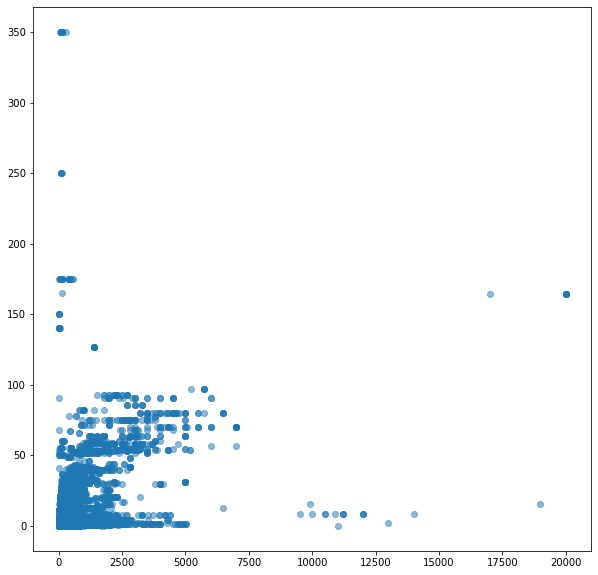

In [1136]:
plt.figure(figsize=(10,10))
plt.scatter(data_train_non_trans_merge_final_dup['price_USD'], data_train_non_trans_merge_final_dup['weight_norm'], alpha=0.5)

In [1137]:
data_train_non_trans_merge_final_dup['price_USD'].corr(data_train_non_trans_merge_final_dup['weight_norm'], method = "spearman")

0.4731423268212986

In [1138]:
brands_explore = data_train_non_trans_merge_final_dup.pivot_table(index=['brand_x'], values=['price_USD'], aggfunc=np.mean).sort_values(by = "price_USD", ascending=False)

In [1139]:
#As we can see, the average price is higher for some brands and lower for others

In [1140]:
brands_explore.head(30)

,price_USD
brand_x,
SunBriteTV,3326.616667
LG,2106.043745
Intel,1915.922727
Marantz,1854.026875
Blue Microphones,1749.990000
MSI,1693.441818
"VIZIO, INC",1692.696250
Nikon,1548.601153
Crane,1403.382174


In [1141]:
#Also the average price can change according to the product condition

In [1142]:
brand = data_train_non_trans_merge_final_dup[(data_train_non_trans_merge_final_dup["brand_x"] == 'Intel') | (data_train_non_trans_merge_final_dup["brand_x"] == 'HP')]

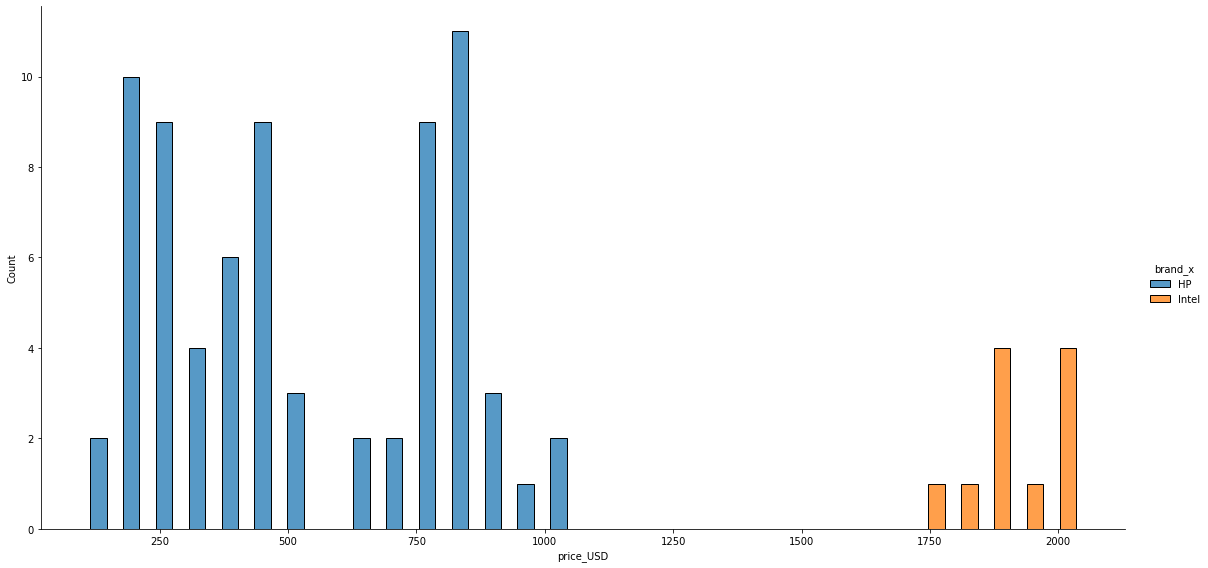

In [1143]:
sns.displot(brand, x="price_USD", hue = 'brand_x', multiple='dodge', bins=30, height=8, aspect=2)

In [1144]:
data_train_non_trans_merge_final_dup.pivot_table(index=['prices_condition'], values=['price_USD'], aggfunc=np.mean)

,price_USD
prices_condition,
,468.990125
For parts or not working,320.194000
Manufacturer refurbished,313.354538
New,507.080031
New other (see details),391.792772
Refurbished,407.551875
Seller refurbished,318.365890
Used,412.073653
new,434.516519


In [1145]:
#As we can see, the average price also changes according to product category

In [1146]:
data_train_non_trans_merge_final_dup.pivot_table(index=['category_2'], values=['price_USD'], aggfunc=np.mean).sort_values(by='price_USD', ascending=False)

,price_USD
category_2,
Lenses & Filters,11247.850833
4K Ultra HD TVs,9954.987500
Projectors,4998.160000
Samsung KS9800,3250.895909
4K Ultra HDTVs,2954.851429
...,...
Camera Bags,24.656667
Wired Microphone Accessories,23.897143
Other Camcorder Accessories,18.866522


In [1147]:
#As we can see, the average price also changes according to manufacturer

In [1148]:
data_train_non_trans_merge_final_dup.pivot_table(index=['manufacturerNumber'], values=['price_USD'], aggfunc=np.mean).sort_values(by='price_USD', ascending=False)

,price_USD
manufacturerNumber,
QN88Q9FAMFXZA,19623.735000
2217,11247.850833
SB-5518HD-WH,5641.594000
OLED65E6P,5128.670645
VPLVW285ES,4998.160000
...,...
LP36651,15.826667
1500518000,14.965556
SP-3001,14.923333


In [1149]:
#As we can see, the average price changes depending on if product is sold under discount

In [1150]:
data_train_non_trans_merge_final_dup.pivot_table(index=['prices_isSale'], values=['price_USD'], aggfunc=np.median).sort_values(by='price_USD', ascending=False)

,price_USD
prices_isSale,
True,260.00
False,179.57


In [1151]:
#As we can see, the average price changes depending on reseller

In [1152]:
merch = data_train_non_trans_merge_final_dup[(data_train_non_trans_merge_final_dup["prices_merchant_x"] == 'samyscamera02') | (data_train_non_trans_merge_final_dup["prices_merchant_x"] == "Green's Camera World")]

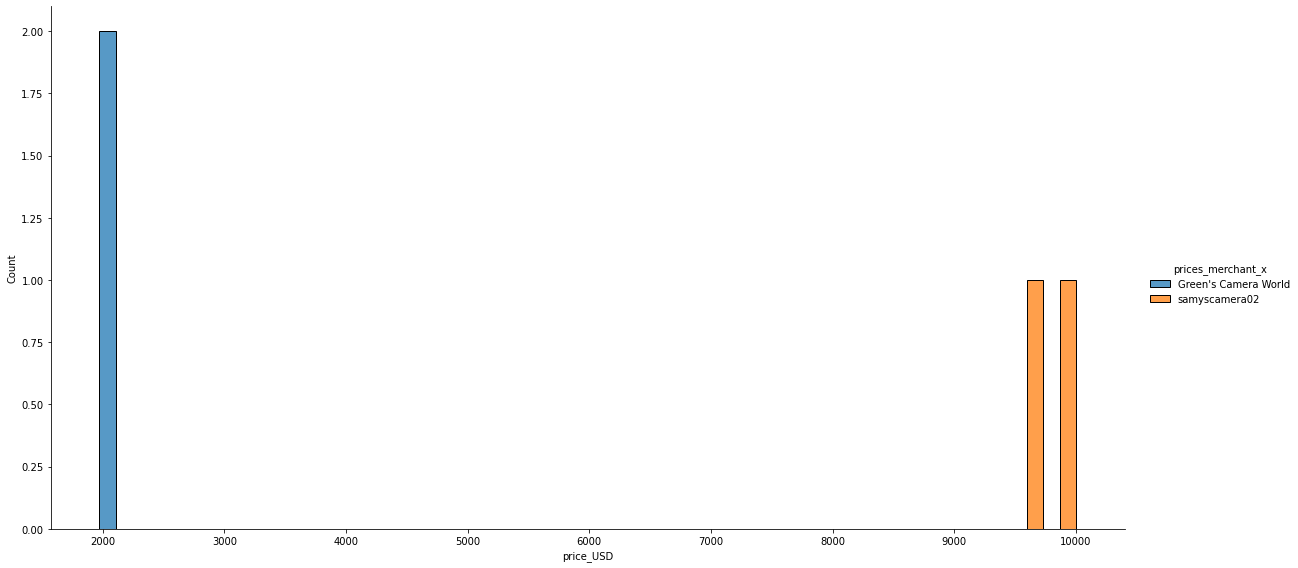

In [1153]:
sns.displot(merch, x="price_USD", hue = 'prices_merchant_x', multiple='dodge', bins=30, height=8, aspect=2)

In [1154]:
#Let's save data set for modelling purposes

In [1155]:
data_train_non_trans_merge_final_dup.to_csv('...data_train_non_trans_merge_final_dup.csv')